# 2016 Olympics Predictions - Who will win a medal?
Based on athlete data from the Olympic games between 1896-2014, we created a  machine learning model to predict who would win a medal in the RIO 2016 Olympic Games. 

We are reading the Olympics athlete's data from Amazon Web Services S3 from a dataset found on  Kaggle (https://www.kaggle.com/pavanraj159/olympics-history-1896-2016/data). 

# Dependencies

In [1]:
import warnings
warnings.simplefilter('ignore')

%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import timedelta
from datetime import datetime
import seaborn as sns

from math import log

from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
# from sklearn.datasets import load_iris

# Loading Data

In [2]:
# # https://www.kaggle.com/pavanraj159/olympics-history-1896-2016/data
olympics = pd.read_csv("https://abe-southside-final-project.s3.us-east-2.amazonaws.com/athlete_events.csv",index_col=[0])
olympics.count()

Name      271116
Sex       271116
Age       261642
Height    210945
Weight    208241
Team      271116
NOC       271116
Games     271116
Year      271116
Season    271116
City      271116
Sport     271116
Event     271116
Medal      39783
dtype: int64

# Reviewing dataframe

In [3]:
# https://www.kaggle.com/pavanraj159/olympics-history-1896-2016/data
olympics.head()

,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
ID,,,,,,,,,,,,,,
1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN
4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN


# Heat Map
#### Using a heat map to highlight Null values

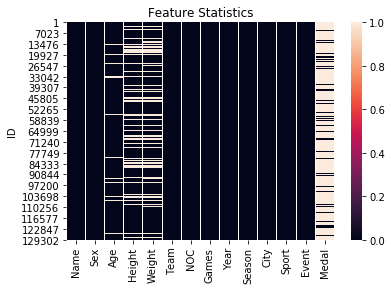

In [4]:
# This data helps us visualize where the null values exist 
sns.heatmap(olympics.isnull())
plt.title("Feature Statistics")
plt.savefig("static/img/NA_Heatmap.png", bbox_inches='tight', pad_inches=0.5)

# Filtering data to fit classification
#### Name of Country (NOC) - Chose top five countries
#### Season - Chose Summer season because it has more sports/data than winter
#### Sport - Chose Athletics (Track and Field) because it has more data point than more data points
#### BMI - Created column using information from columns Height and Weight

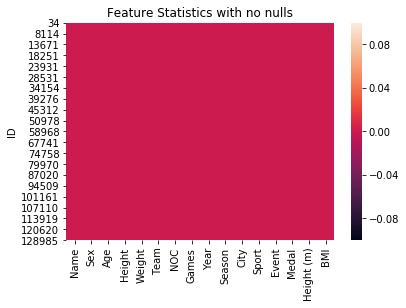

In [5]:
countries = ['USA','BRA','GER','AUS','FRA']
sports = ['Athletics']

olympics = olympics[olympics['NOC'].isin(countries)]
olympics = olympics[olympics['Season'] == 'Summer']
# olympics = olympics[olympics['Sport'].isin(sports)]
# olympics = olympics[olympics['Sex']== 'M']
olympics = olympics[olympics['Height'].notna()]
olympics = olympics[olympics['Age'].notna()]
olympics['Height (m)'] = olympics['Height']/100
olympics = olympics[olympics['Weight'].notna()] 
olympics['BMI'] = round(olympics['Weight']/(olympics['Height (m)']*olympics['Height (m)']),2)
# olympics = olympics[olympics['Medal'] == 'Gold']
# wins = ['Gold','Bronze']
# olympics = olympics[olympics['Medal'].isin(wins)]

olympics.loc[(olympics['Medal'] == 'Gold'),'Medal']='Medal'
olympics.loc[(olympics['Medal'] == 'Silver'),'Medal']='Medal'
olympics.loc[(olympics['Medal'] == 'Bronze'),'Medal']='Medal'
olympics.loc[(olympics['Medal'].isna()),'Medal']= 'Non-Medal'

olympics_df = olympics[olympics['Year']< 2016]
olympics_2016 = olympics[olympics['Year'] == 2016]

# This heatmap shows us that there are no null values
sns.heatmap(olympics.isnull())
plt.title("Feature Statistics with no nulls")
plt.savefig("static/img/Clean_Heatmap.png", bbox_inches='tight', pad_inches=0.5)

#### Saving dataframe to csv

In [6]:
olympics_df.to_csv("static/dataset/olympics_df.csv", index=False)
olympics_2016.to_csv("static/dataset/olympics_2016.csv", index=False)

### Showing which countries have the highest count

In [7]:
olympics_2016.groupby(['NOC']).count().sort_values('BMI',ascending = False)
olympics_2016.to_csv("static/dataset/olympics_2016_bmi.csv", index=False)

# Reviewing scatter plots of various features to identify correlation

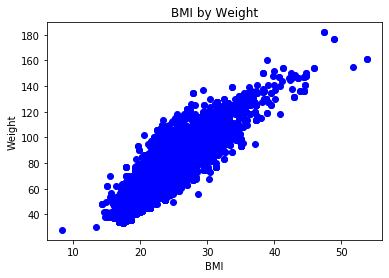

In [8]:
H = olympics_df['Height (m)']
W = olympics_df['Weight']
A = olympics_df['Age']
B = olympics_df['BMI']
M = olympics_df['Medal']

plt.scatter(B,W,c="blue")
plt.xlabel("BMI")
plt.ylabel("Weight")
plt.title("BMI by Weight")
plt.savefig("static/img/BMI_Weight.png", bbox_inches='tight', pad_inches=0.5)

#### BMI by Height

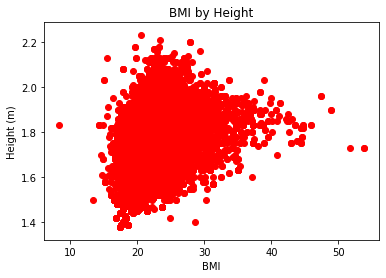

In [9]:
plt.scatter(B,H,c="red")
plt.xlabel("BMI")
plt.ylabel("Height (m)")
plt.title("BMI by Height")
plt.savefig("static/img/BMI_Height.png", bbox_inches='tight', pad_inches=0.5)

#### BMI by Age

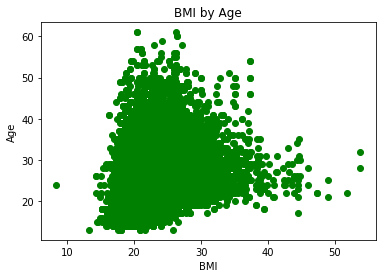

In [10]:
plt.scatter(B,A,c="green")
plt.xlabel("BMI")
plt.ylabel("Age")
plt.title("BMI by Age")
plt.savefig("static/img/BMI_Age.png", bbox_inches='tight', pad_inches=0.5)

#### Medal by BMI

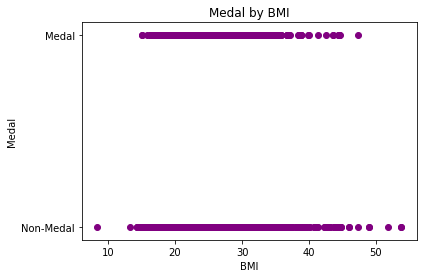

In [11]:
plt.scatter(B,M,c="purple")
plt.xlabel("BMI")
plt.ylabel("Medal")
plt.title("Medal by BMI")
plt.savefig("static/img/Medal_BMI.png", bbox_inches='tight', pad_inches=0.5)

# Logistic Regression
## Preparing features columns and output of x and y

In [12]:
X = pd.get_dummies(olympics_df[["Sex", "Age", "Height", "Weight","BMI","NOC"]])
# X = olympics[["BMI","NOC"]]
y = olympics_df["Medal"]
print(X.shape, y.shape)
print(X)
print(y)

(29204, 11) (29204,)
         Age  Height  Weight    BMI  Sex_F  Sex_M  NOC_AUS  NOC_BRA  NOC_FRA  \
ID                                                                             
34      30.0   187.0    76.0  21.73      0      1        0        0        1   
52      22.0   189.0    80.0  22.40      0      1        0        0        1   
73      23.0   182.0    86.0  25.96      0      1        0        0        1   
73      27.0   182.0    86.0  25.96      0      1        0        0        1   
84      26.0   165.0    55.0  20.20      0      1        0        0        0   
...      ...     ...     ...    ...    ...    ...      ...      ...      ...   
135528  28.0   181.0    75.0  22.89      0      1        0        0        0   
135530  23.0   202.0    98.0  24.02      0      1        0        0        0   
135531  24.0   172.0    52.0  17.58      1      0        0        0        0   
135543  25.0   175.0    64.0  20.90      0      1        0        0        0   
135566  21.0   175.

## Fitting x and y using sklearn

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

#### Creating test dataset to run the machine learning model on

In [14]:
X_2016 = pd.get_dummies(olympics_2016[["Sex", "Age", "Height", "Weight","BMI","NOC"]])
X_2016

,Age,Height,Weight,BMI,Sex_F,Sex_M,NOC_AUS,NOC_BRA,NOC_FRA,NOC_GER,NOC_USA
ID,,,,,,,,,,,
73,31.0,182.0,86.0,25.96,0,1,0,0,1,0,0
149,30.0,163.0,52.0,19.57,1,0,0,0,0,0,1
402,30.0,184.0,85.0,25.11,0,1,0,0,0,1,0
444,31.0,168.0,60.0,21.26,1,0,0,0,1,0,0
451,21.0,175.0,75.0,24.49,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
134960,23.0,193.0,89.0,23.89,0,1,0,0,0,0,1
134998,20.0,179.0,68.0,21.22,0,1,0,0,0,1,0
135037,32.0,184.0,70.0,20.68,0,1,0,1,0,0,0


In [15]:
y_2016 = olympics_2016["Medal"]
y_2016

ID
73            Medal
149       Non-Medal
402       Non-Medal
444       Non-Medal
451       Non-Medal
            ...    
134960    Non-Medal
134998    Non-Medal
135037    Non-Medal
135525        Medal
135528    Non-Medal
Name: Medal, Length: 2857, dtype: object

## Classifying data for Logistic Regression

In [16]:
classifier = LogisticRegression()
classifier.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

#### Scoring classifiers

In [17]:
print(f"Training Data Score: {classifier.score(X_train, y_train)}")
print(f"Testing Data Score: {classifier.score(X_test, y_test)}")

Training Data Score: 0.7643245217550108
Testing Data Score: 0.7651006711409396


#### Machine learning model predictions tested on 2016 data

In [18]:
predictions = classifier.predict(X_2016)
print(f"First 10 Predictions:   {predictions[:10]}")
print(f"First 10 Actual labels: {y_2016[:10].tolist()}")

First 10 Predictions:   ['Non-Medal' 'Non-Medal' 'Non-Medal' 'Non-Medal' 'Non-Medal' 'Non-Medal'
 'Non-Medal' 'Non-Medal' 'Non-Medal' 'Non-Medal']
First 10 Actual labels: ['Medal', 'Non-Medal', 'Non-Medal', 'Non-Medal', 'Non-Medal', 'Non-Medal', 'Medal', 'Non-Medal', 'Non-Medal', 'Non-Medal']


In [19]:
Testing = pd.DataFrame({"Prediction": predictions, "Actual": y_2016}).reset_index(drop=True)
Testing

,Prediction,Actual
0,Non-Medal,Medal
1,Non-Medal,Non-Medal
2,Non-Medal,Non-Medal
3,Non-Medal,Non-Medal
4,Non-Medal,Non-Medal
...,...,...
2852,Non-Medal,Non-Medal
2853,Non-Medal,Non-Medal
2854,Non-Medal,Non-Medal
2855,Non-Medal,Medal


In [20]:
Testing_crosstab = pd.crosstab(Testing['Actual'],Testing['Prediction'])
Testing_crosstab

Prediction,Medal,Non-Medal
Actual,,
Medal,55,595
Non-Medal,25,2182


## Visualize Actuals and Predictions
#### Based on historical summer olympics (Athletics) prior to 2016 dataset, we were 78% accurate with identifyiing people that won and did not win medals in the 2016 olympics.

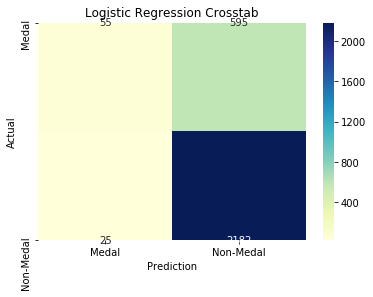

In [21]:
lr_heatmap = sns.heatmap(Testing_crosstab, cmap="YlGnBu",fmt='g', annot=True, cbar=True, annot_kws = {'ha': 'center','va': 'center'})
bottom, top = lr_heatmap.get_ylim()
lr_heatmap.set_ylim(bottom, top)
plt.title("Logistic Regression Crosstab")
plt.savefig("static/img/LR_Crosstab_heatmap.png", bbox_inches='tight', pad_inches=0.5)

#### Reviewing prediction data

In [22]:
# Testing[(Testing['Actual'] != 'Others') & (Testing['Prediction'] != 'Others')]
# Testing[(Testing['Prediction'] == 'Non-Medal')]
Testing[(Testing['Prediction'] == 'Medal')]

,Prediction,Actual
13,Medal,Medal
16,Medal,Medal
17,Medal,Medal
18,Medal,Medal
19,Medal,Medal
...,...,...
2593,Medal,Medal
2637,Medal,Medal
2675,Medal,Non-Medal
2742,Medal,Non-Medal


# Decision Tree
#### Shows the weight of each feature importance

In [23]:
X = pd.get_dummies(olympics_df[["Sex", "Age", "Height", "Weight","BMI","NOC"]])
y = olympics_df["Medal"].values.reshape(-1,1)
print(X.shape, y.shape)
feature_names = X

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)


clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
clf.score(X_test, y_test)

rf = RandomForestClassifier(n_estimators=200)
rf = rf.fit(X_train, y_train)
rf.score(X_test, y_test)

sorted(zip(rf.feature_importances_, feature_names), reverse=True)

(29204, 11) (29204, 1)


[(0.31959269707563914, 'Age'),
 (0.24416830848518442, 'BMI'),
 (0.17946152105508856, 'Weight'),
 (0.17810308191673815, 'Height'),
 (0.0349371286995999, 'NOC_USA'),
 (0.010832055629575128, 'NOC_FRA'),
 (0.007693796384260054, 'Sex_M'),
 (0.007120874267738274, 'Sex_F'),
 (0.006545841535846836, 'NOC_AUS'),
 (0.005985657874968793, 'NOC_GER'),
 (0.005559037075360893, 'NOC_BRA')]

# Random Forest
#### Shows the weight of each feature importance
#### Validated Decision Tree results

In [33]:
# Create a random forest classifier
rf = rf.fit(X, y)
rf.score(X, y)

# Random Forests in sklearn will automatically calculate feature importance
importances = rf.feature_importances_
importances

# We can sort the features by their importance
features = sorted(zip(rf.feature_importances_, X), reverse=True)
featuresgit 

[(0.32130431458262454, 'Age'),
 (0.24391373321532805, 'BMI'),
 (0.17780068238387392, 'Weight'),
 (0.17716096947207247, 'Height'),
 (0.03579203598810713, 'NOC_USA'),
 (0.011633671548318486, 'NOC_FRA'),
 (0.007922334200027643, 'Sex_F'),
 (0.007457540521189609, 'Sex_M'),
 (0.006504244738944442, 'NOC_AUS'),
 (0.005622377857902487, 'NOC_GER'),
 (0.004888095491611179, 'NOC_BRA')]

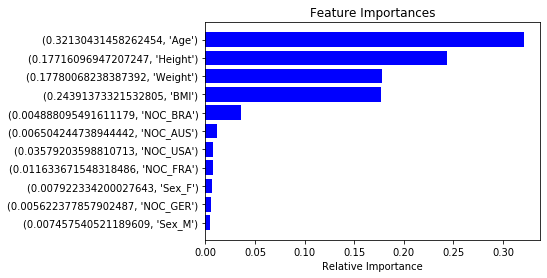

<Figure size 432x288 with 0 Axes>

In [37]:
# features = iris['feature_names']
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()
plt.savefig("static/img/Feature_Importance.png", bbox_inches='tight', pad_inches=0.5)